## Initial Version of the code

#### Todo:
    - Give some more values of Initial Values -> Done
    - Play With the Value of Alpha -> Done


In [1]:
#* Imports

import numpy as np 
import matplotlib.pyplot as plt #* For Plotting
import scipy as sp
from scipy import integrate #* For Solving Differential Equations
import snoop  #* For Debugging Purpose

from scipy.optimize import brentq 
from numbalsoda import lsoda_sig, lsoda,solve_ivp #Faster Method
import numba as nb #For Speeding Up
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline

In [2]:
#Parameters

mu=1.0 #! This Value was not given in paper. I solved it 
        #! using the constraint on the total energy
M=1.
L=1.
z0=0.5
alpha=0.01  #TODO Important Parameter. 

The Hamiltonian is : <br> <br>
$\mu*(pw^2/2\mu + pz^2/2\mu + L^2/(2 \mu^2 w^2) - M/\sqrt{w^2 + z^2} + \alpha z_0 \log(\cosh(z/z_0)))$

$L= p_{\phi} \;\;\;\;\;!$

In [3]:
@nb.njit
def logcosh(x):
    # s always has real part >= 0
    s = np.sign(x) * x
    p = np.exp(-2 * s)
    return s + np.log1p(p) - np.log(2)
@nb.njit
# @snoop
def H(mu: np.float64,ics: np.ndarray,alpha: np.int32) -> np.ndarray:
    """

    Args:
        mu (float): Mass of the Test Particle
        ics (np.ndarray): The Phase Space Coordinates of the particle
                        Shape(n,4)

    Returns:
        Energy of the particel (np.ndarray): Shape (n,)
    """
    if ics.ndim==1:
        w,z,phi,pw,pz,pphi=ics[0],ics[1],ics[2],ics[3],ics[4],ics[5]
    else:
        w,z,phi,pw,pz,pphi=ics[:,0],ics[:,1],ics[:,2],ics[:,3],ics[:,4],ics[:,5]
    L= pphi

    return mu*(pw**2/(2*mu) + pz**2/(2*mu) + L**2/(2* mu**2*w**2) - M/np.sqrt(w**2 + z**2) + alpha*z0*logcosh(z/z0))

In [4]:
ics=np.array([1.2,0.0,0.0,0.0,0.76,L]) #* Initial conditions w,z,phi, pw,pz,pphi from paper

In [5]:
t=np.arange(0.,100000.,1) #Time Steps for evolution

In [6]:
t.shape

(100000,)

In [7]:
def evolve(t: float,x: np.ndarray,alpha: int)-> np.ndarray:
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    w,z,phi,pw,pz,pphi=x
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /(mu**2 * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0

    return np.array((dw,dz,dphi,dpw,dpz,dpphi))


In [8]:
# @nb.cfunc('')
def poincare(t: float,y: np.ndarray,args:np.int32)-> float:
    """Creating Poincare Section 

    Args:
        t (float): time Step
        y (np.ndarray): Shape (n,4)
        args (np.int32) : Not needed. But used for compatibility for
                            below methods

    Returns:
        float: The value where the function gets zero (z value in this case)
    """
    return y[1]


In [35]:
sol=integrate.solve_ivp(evolve,(0.,t[-1]),ics,'LSODA',t_eval=t,events=poincare,dense_output=True,args=(alpha,),atol=1e-11,rtol=1e-11)

In [ ]:
cs= CubicSpline(sol.t,sol.y.T)

In [ ]:
mask=sol.y_events[0][:,4]>0  #* Get those values where v_z is greater than zero

In [ ]:

#* Poincare Plot
 
plt.scatter(sol.y_events[0][mask,0],sol.y_events[0][mask,3],s=0.2);
plt.title(r"Poincare Plot for z=0");
plt.xlabel(r"w");
plt.ylabel(r"$p_w$");

In [ ]:
# plt.plot(sol.y[1])

In [ ]:
energy=H(mu,sol.y.T,alpha=alpha) #Get the energy of given solutions

In [ ]:
plt.plot(energy) 
plt.title("Energy vs time")
plt.xlabel("Time")
plt.ylabel("Energy")

#* The value of energy is within -0.2 (+/- 39e^(-8))

In [ ]:
np.isclose(np.diff(energy),0).all()
#! All the values of energy are within 1e^(-8)

In [ ]:

#! Faster Methods -----------------------------------

- <span style="color:red"> The following method generate the solutions very fast
 But it is very slow if you want to generate the Poincare
 Sections. We do not need this now. But I had put it for future reference </span>

##  <span style= "color:orange">Using LSODA wrapper </span>

In [ ]:
#Faster Version of evolve method above
@nb.cfunc(lsoda_sig)
def faster_evolve(t,u, du,p):
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    # w,z, phi,pw,pz,pphi=x
    p_=nb.carray(p,(1,))
    alpha=p_[0]
    du[0]= u[3]
    du[1]= u[4]
    du[2]= L/(mu*u[0]**2)

    du[3]= -mu*(-L**2 /(mu**2 * u[0]**3) + M*u[0]/((u[0]**2+u[1]**2)**(3/2)))
    du[4]=-mu*(M*u[1]/((u[0]**2+u[1]**2)**(3/2))+ alpha*np.tanh(u[1]/z0))
    du[5]=0.0

    # return np.array((dw,dz,dphi,dpw,dpz,dpphi))


In [ ]:
funcptr=faster_evolve.address

In [ ]:
u0=np.array([1.2,0.0,0.0,0.0,0.76,L]) #Initial conditions

In [ ]:
t=np.arange(0.,100000.,1) #Time Steps for evolution

In [ ]:
n_events=6000

@nb.cfunc(lsoda_sig)
def poincare_event(t,u,out,p):
    for i in nb.prange(n_events):
        out[i]=u[1]

# jitted_events = nb.njit(poincare_event)
event_fcn=poincare_event.address

In [ ]:
t_span=np.array([min(t),max(t)])

In [ ]:
t_eval=np.arange(0,10000,1)

In [ ]:
usol, success = lsoda(funcptr, u0, t,data=np.array((alpha)),atol=1e-12,rtol=1e-12)

In [ ]:
H(1.00,usol,alpha)

In [ ]:
#Now, to make the poincare plot

#---------------Work in Progress------------------


In [ ]:
idx2 = np.where(np.sign(usol[:,1][:-1]) != np.sign(usol[:,1][1:]))[0] + 1
idx1=idx2-1

In [ ]:
# f=lambda t: lsoda(funcptr,u0 , np.array([0,t]), mxstep=5000000,atol=1e-10, rtol=1e-10)[0][-1,1];
# t_eval=np.zeros_like(idx1)

# for i in range(1,len(idx2)):
#     t_eval[i]=brentq(f,t[idx1[i]],t[idx2[i]])

# # t_eval=np.array(t_eval)

In [ ]:
# plt.plot(t,H(mu,usol))

## <span style="color: magenta">Lyponov Exponents</span>

## What will we try

- The first step is to try the things as was done for Lorenz System
- We will copy the code with minor changes

- In the next step, we will use the same thing as above, only difference will be that it will be faster than above

In [25]:
#Step 1

In [26]:
#Using the method given in the paper

In [9]:
def chaotic_lyp(t,Y,alpha=alpha):
    """
    Function for solving the system of equation simultaneously with
    the Jacobian

    """

    #First system of equations
    
    w,z,phi,pw,pz,pphi=Y[:6]
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /((mu**2) * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0  

    dhdwdw=-mu*(3*L**2/((mu**2)*(w**4))-3*M*w**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2)))
    dhdwdz= 3*M*mu*w*z/((w**2+z**2)**(5/2))
    dhdzdz=-mu*(-3*M*z**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2))+alpha*(1/(np.cosh(z/z0))**2)/z0)

    #Now calculate the jacobian
    J=np.array([

        [0., 0.,0.,1.,0.,0.],
        [0.,0.,0.,0.,1.,0.],
        [-2*L/(mu*w**3), 0.,0.,0.,0.,1/(mu*w**2)],
        [dhdwdw,dhdwdz,0.,0.,0.,2*L/(mu*w**3)],
        [dhdwdz,dhdzdz,0.,0.,0.,0.],
        [0.,0.,0.,0.,0.,0.]
    ])

    dY=Y[6:].reshape((6,1))
    dY_dt=np.dot(J,dY)

    return np.concatenate(([dw,dz,dphi,dpw,dpz,dpphi],dY_dt.flatten()))

In [10]:

#! Faster implementaton of above function
@nb.cfunc(lsoda_sig)
def faster_chaotic_system(t,u,du,p):
    """
    The same system as above but faster than above method. This uses Numba
    and Numbalsoda for faster evaluations
    """
    u_=nb.carray(u,(12,))
    p_=nb.carray(p,(1,))
    alpha=p_[0]
    w,z,phi,pw,pz,pphi=u_[:6]
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /((mu**2) * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0  

    dhdwdw=-mu*(3*L**2/((mu**2)*w**4)-3*M*w**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2)))
    dhdwdz= 3*M*mu*w*z/((w**2+z**2)**(5/2))
    dhdzdz=-mu*(-3*M*z**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2))+alpha*(1/(np.cosh(z/z0))**2)/z0)

    #Now calculate the jacobian

    J=np.array([
        [0., 0.,0.,1.,0.,0.],
        [0.,0.,0.,0.,1.,0.],
        [-2*L/(mu*w**3), 0.,0.,0.,0.,1/(mu*w**2)],
        [dhdwdw,dhdwdz,0.,0.,0.,2*L/(mu*w**3)],
        [dhdwdz,dhdzdz,0.,0.,0.,0.],
        [0.,0.,0.,0.,0.,0.]
    ])

    dY=u_[6:].reshape((6,1))
    dY_dt=np.dot(J,dY)
    dydtf=dY_dt.flatten()
    du_=np.zeros((12,),dtype=nb.float64)
    du_[:6]=np.array([dw,dz,dphi,dpw,dpz,dpphi])
    du_[6:]=dydtf

    for i in range(len(du_)):
        du[i]=du_[i]



In [11]:
pfunctptr=faster_chaotic_system.address

In [12]:
u0=np.array([1.2,0.0,0.0,0.0,0.76,L]) #Initial condition for x(0)
w0=np.random.normal(0.,1.,(6))
w0=w0/np.linalg.norm(w0) #Initial unitary deviation vector w(0)

In [13]:
ics0=np.array((u0,w0)).flatten() #Combined Initial vector

In [14]:
tau=1000  #Renormalization time
tf=1000000. #Final time

In [38]:

@nb.njit
def evolve_lyap(ics0,tau,tf,alpha,steps, sanity_check):

    ti=0.  #* Initial Time
    timestep=np.arange(ti,tf,tau) #* Time interval
    size=timestep.shape[0] 

    X1t=np.zeros((size-1)) #*Lyapunaov Exponents
    sum=0.0
    ics=ics0.copy()  #*We do not want to change our initial conditions
    h=np.zeros(size-1) #*Check for energy
    sol=np.zeros((size,6))
    sol[0,:]=ics[:6]
    # traj=np.zeros((steps,6),dtype=np.float64)

    for i in range(0,size-1):
        timeint=np.linspace(timestep[i],timestep[i+1],steps) #!Our time interval with 10000 points between them

        usol_,_=lsoda(pfunctptr,ics,t_eval=timeint,data=np.array((alpha)),rtol=1e-12,atol=1e-12,mxstep=100000) #* Solver
        if i==0:
            traj=np.zeros_like(usol_)
            traj=usol_

        usol=usol_[-1]

        #Uncomment following line to use scipy solver and comment above two lines
        # usol=integrate.solve_ivp(chaotic_lyp_paper,[0.,tf],ics0,'LSODA',t_eval=timeint,atol=1e-10,rtol=1e-10).y[:,-1] 
        
        xk=usol[:6]  #Orbit at t= tau
        wk=usol[6:]  #Deviations at t=tau

        #*---------------------The following algorithm is from the paper

        alphak=np.linalg.norm(wk) 
        sum=sum+np.log(alphak)
        X1t[i]=sum/timestep[i+1]
        wk0=wk/alphak

        #*----------------------Lyapunaov Exponents calculated above
        #! Now for another time step. Set the current solution as the initial conditions for next time steps
        ics[:6]=xk
        ics[6:]=wk0

        #! ------------------------Sanity Check--------------------------
        # if sanity_check!=0:
        h[i]=H(1.00,ics,alpha) #! Current Energy
        sol[i+1,:]=ics[:6]
        #! Comment above line if you do not want to perform the sanity check

    # if sanity_check!=0:
    #     return X1t,h,sol, traj
    
    return X1t,h,sol,traj


In [17]:
alpha=0.1 #*Current alpha

In [18]:
steps=10000 #*Number of time steps between each time interval 

In [19]:
_,energy_,sol_=evolve_lyap(ics0,tau,5000.,alpha,steps,0)  #!Run it for the first time so that numba understands the call signature

TypeError: not enough arguments: expected 6, got 5

In [37]:
lyaps1=evolve_lyap(ics0,tau,tf,alpha,steps) #* Lyapunaov Exponents. 

#! If you get a warning the t+h_=t on the next step, ignore it.

lsoda -- warning..internal t = 660980 and h_ = 3.9006e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 660980 and h_ = 3.9006e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 660980 and h_ = 3.9006e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 660980 and h_ = 3.9006e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 682531 and h_ = 4.82687e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 682531 and h_ = 4.82687e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..in

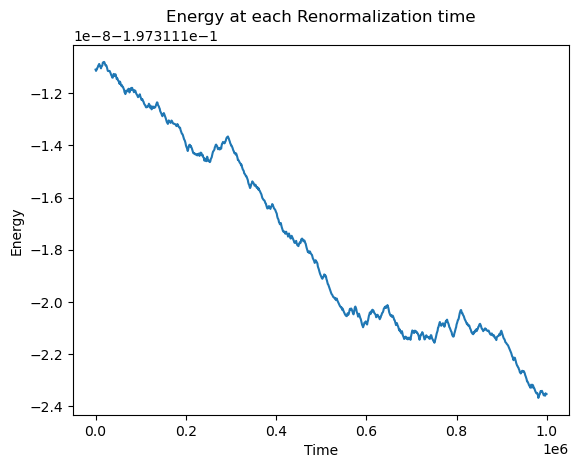

In [49]:
plt.plot(np.linspace(0.,tf,tau)[:-1],lyaps1[1]) #! Sanity check: Energy
plt.title("Energy at each Renormalization time")
plt.xlabel('Time');
plt.ylabel('Energy');

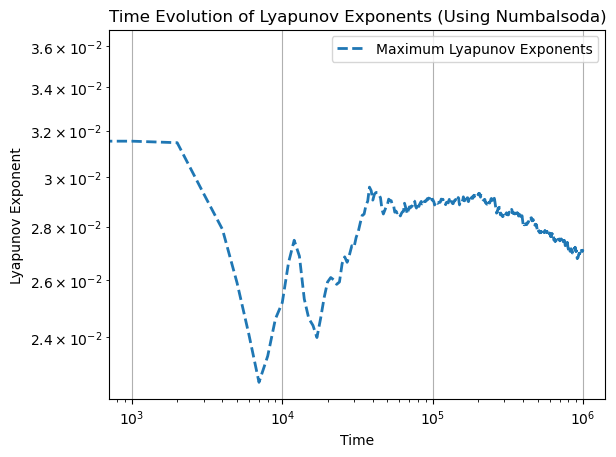

In [39]:
plt.figure()
plt.plot(np.arange(0.,tf,1000)[:-2],lyaps1[0][:-1],label='Maximum Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
# plt.xlim(1e4,1e6)
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents (Using Numbalsoda)')
plt.show()

In [20]:
alpha=0.01 #* Next case

In [39]:
lyaps2=evolve_lyap(ics0,tau,tf,alpha,steps,1)

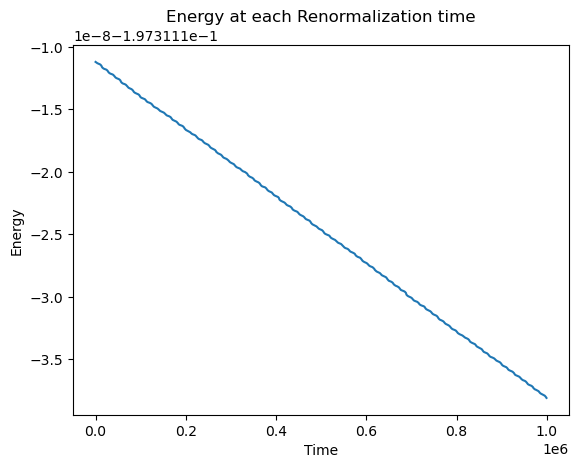

In [42]:
plt.plot(np.linspace(0.,tf,tau)[:-1],lyaps2[1]) #! Sanity check: Energy
plt.title("Energy at each Renormalization time")
plt.xlabel('Time');
plt.ylabel('Energy');

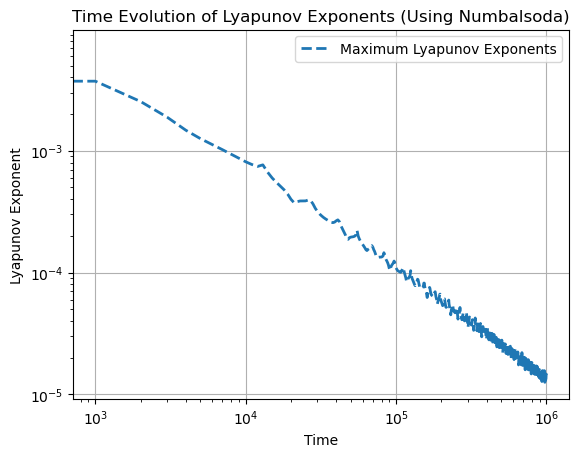

In [43]:
plt.figure()
plt.plot(np.arange(0.,tf,1000)[:-2],lyaps2[0][:-1],label='Maximum Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
# plt.xlim(1e4,1e6)
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents (Using Numbalsoda)')
plt.show()

In [51]:
alpha=10.

In [52]:
lyaps3=evolve_lyap(ics0,tau,tf,alpha,steps)

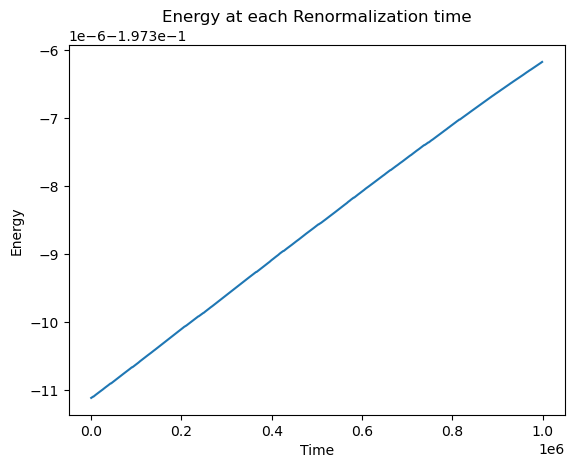

In [53]:
plt.plot(np.linspace(0.,tf,tau)[:-1],lyaps3[1])
plt.title("Energy at each Renormalization time")
plt.xlabel('Time');
plt.ylabel('Energy');

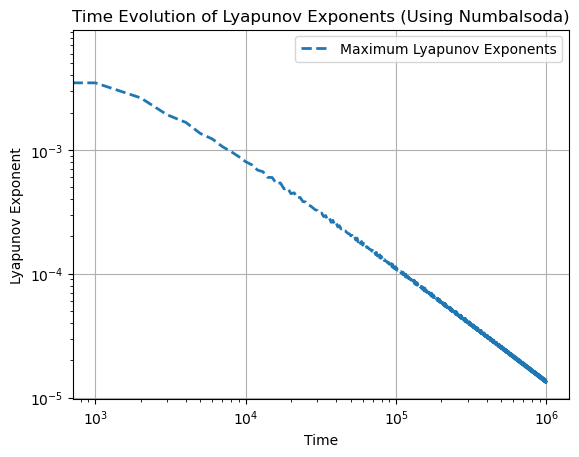

In [54]:
plt.figure()
plt.plot(np.arange(0.,tf,1000)[:-2],lyaps3[0][:-1],label='Maximum Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
# plt.xlim(1e4,1e6)
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents (Using Numbalsoda)')
plt.show()

In [48]:
#!Sanity Checks

In [185]:
alpha=0.01

#!Time step is 1000/(sti) where sti is one of the below.
#!Eg: If sti=10000, time step is 1000/10000=0.1 and so on
st1=10000
st2=50000
st3=100000
st4=1000000

In [186]:
tau

1000

In [187]:

#! For the sanity check, we want only the solutions
L1,h1,sol1,sol01=evolve_lyap(ics0,tau,tf,alpha,st1,0)
L2,h2,sol2,sol02=evolve_lyap(ics0,tau,tf,alpha,st2,0)
L3,h3,sol3,sol03=evolve_lyap(ics0,tau,tf,alpha,st3,0)
L4,h4,sol4,sol04=evolve_lyap(ics0,tau,tf,alpha,st4,0)

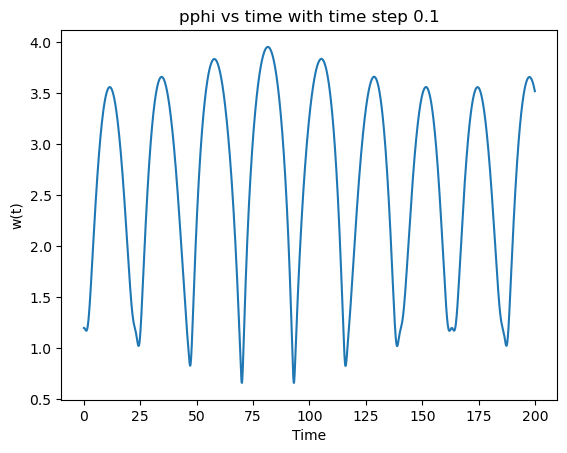

In [188]:
plt.plot(np.linspace(0.,1000.,st1)[:2000],sol01[:2000,0]);
plt.title("pphi vs time with time step 0.1")
plt.xlabel('Time')
plt.ylabel('w(t)');
plt.savefig('fig10000.png')

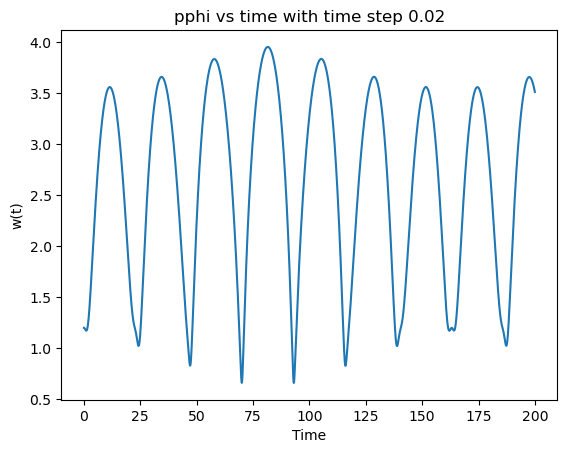

In [189]:
plt.plot(np.linspace(0.,1000,st2)[:10000],sol02[:10000,0]);
plt.title("pphi vs time with time step 0.02")
plt.xlabel('Time')
plt.ylabel('w(t)');
plt.savefig('fig50000.png')

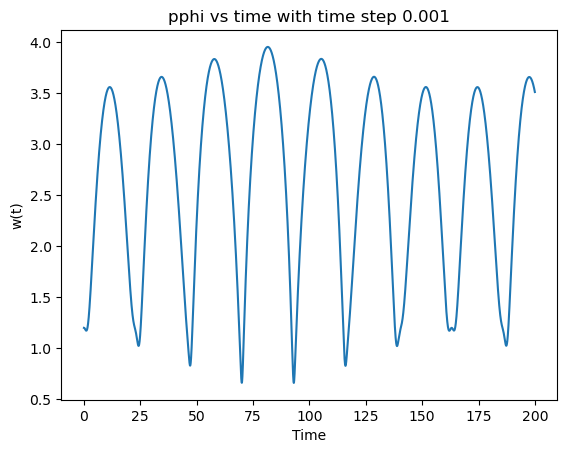

In [190]:
plt.plot(np.linspace(0.,1000.,st3)[:20000],sol03[:20000,0]);
plt.title("pphi vs time with time step 0.001")
plt.xlabel('Time')
plt.ylabel('w(t)');
plt.savefig('fig100000.png')

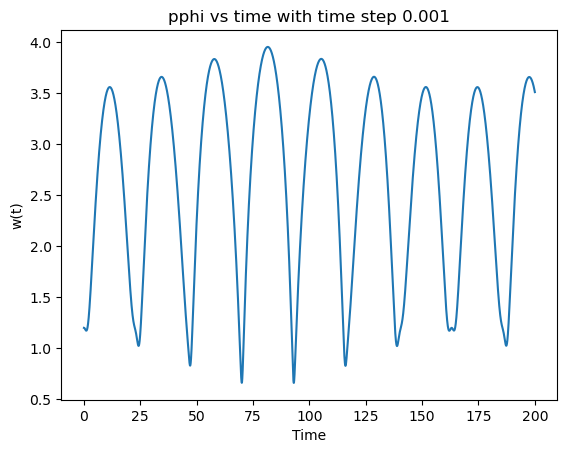

In [191]:
plt.plot(np.linspace(0.,1000.,st4)[:200000],sol04[:200000,0]);
plt.title("pphi vs time with time step 0.001")
plt.xlabel('Time')
plt.ylabel('w(t)');
plt.savefig('fig100000.png')

Text(0.5, 1.0, 'Trajectory w vs time for different time steps for first 100 seconds ')

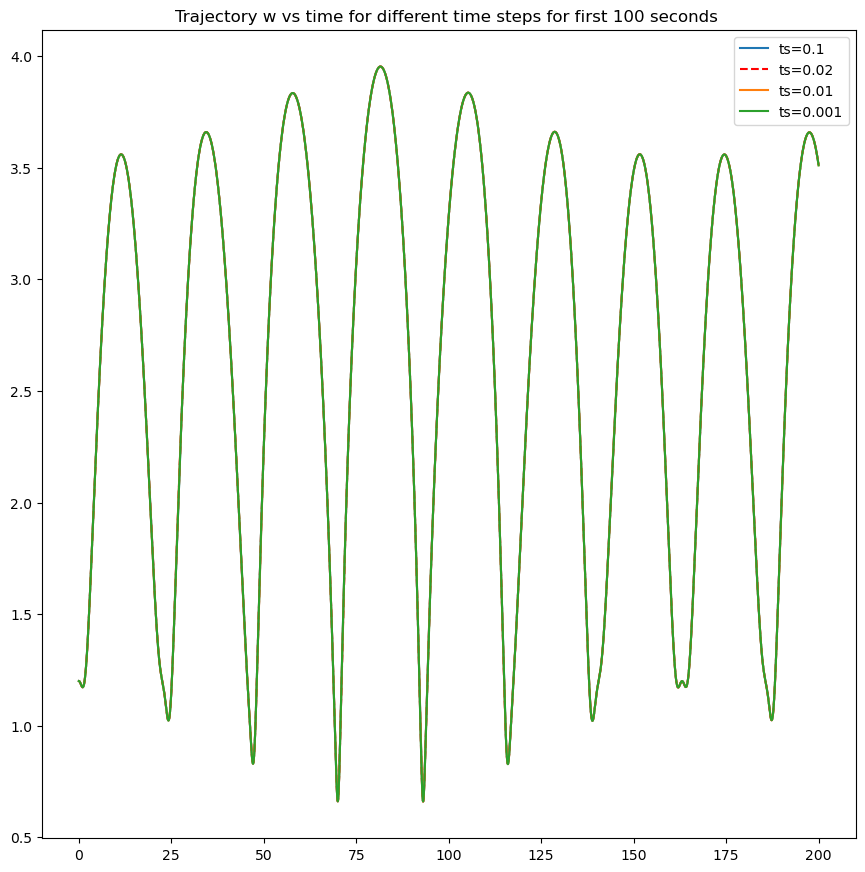

In [192]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(np.linspace(0.,1000.,st1)[:2000],sol01[:2000,0],label=f"ts={1000/st1}");
plt.plot(np.linspace(0.,1000,st2)[:10000],sol02[:10000,0],'r--',label=f"ts={1000/st2}");
plt.plot(np.linspace(0.,1000.,st3)[:20000],sol03[:20000,0],label=f"ts={1000/st3}");
plt.plot(np.linspace(0.,1000.,st4)[:200000],sol04[:200000,0],label=f"ts={1000/st4}");
plt.legend()
plt.title("Trajectory w vs time for different time steps for first 100 seconds ")
# plt.savefig("Timesteps.pdf",dpi=800)

In [193]:
h4.shape

(999,)

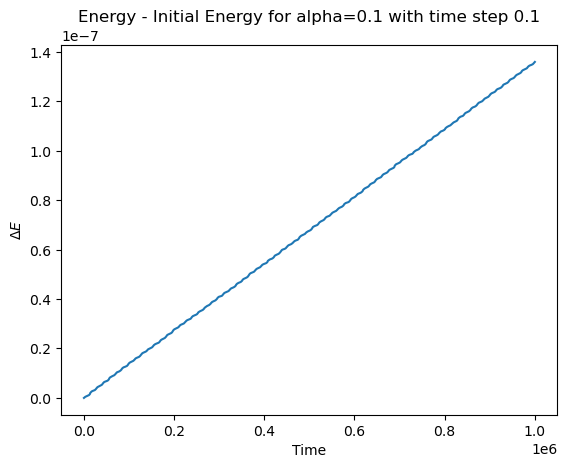

In [194]:
plt.plot(np.linspace(0.,1000000.,999),(h1-h1[0])/h1[0])
plt.title(f'Energy - Initial Energy for alpha=0.1 with time step {1000/10000}')
plt.ylabel('$\Delta E$')
plt.xlabel('Time')
plt.savefig('E01.png')

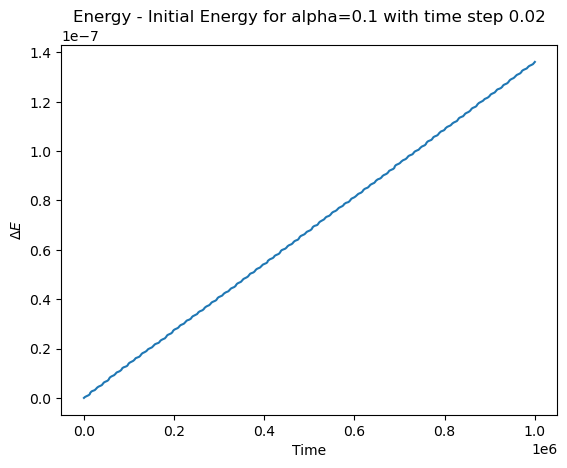

In [195]:
plt.plot(np.linspace(0.,1000000.,999),(h2-h2[0])/h2[0])
plt.title(f'Energy - Initial Energy for alpha=0.1 with time step {1000/st2}')
plt.ylabel('$\Delta E$')
plt.xlabel('Time')
plt.savefig('E002.png')

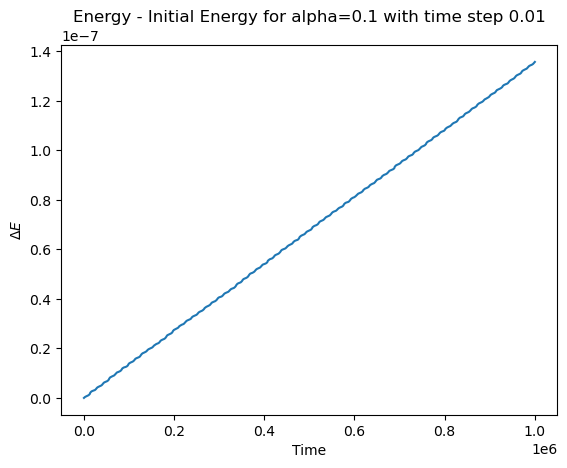

In [196]:
plt.plot(np.linspace(0.,1000000.,999),(h3-h3[0])/h3[0])
plt.title(f'Energy - Initial Energy for alpha=0.1 with time step {1000/st3}')
plt.ylabel('$\Delta E$')
plt.xlabel('Time')
plt.savefig('E001.png')

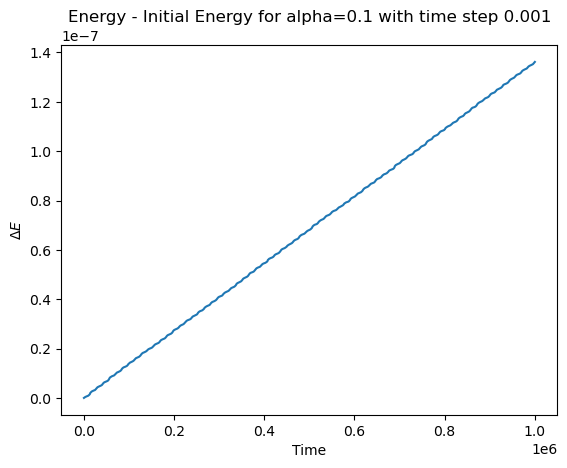

In [197]:
plt.plot(np.linspace(0.,1000000.,999),(h4-h4[0])/h4[0])
plt.title(f'Energy - Initial Energy for alpha=0.1 with time step {1000/st4}')
plt.ylabel('$\Delta E$')
plt.xlabel('Time')
plt.savefig('E0001.png')

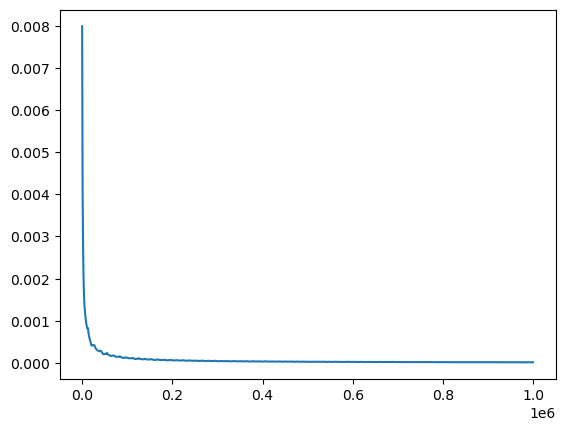

In [198]:
plt.plot(np.linspace(0.,1000000.,999),L1)

# <span style="color: Yellow">Gravitational Wave Forms</span>

In [9]:
@nb.cfunc(lsoda_sig)
def faster_evolve(t,u, du,p):
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    # w,z, phi,pw,pz,pphi=x
    p_=nb.carray(p,(1,))
    alpha=p_[0]
    du[0]= u[3]
    du[1]= u[4]
    du[2]= L/(mu*u[0]**2)

    du[3]= -mu*(-L**2 /(mu**2 * u[0]**3) + M*u[0]/((u[0]**2+u[1]**2)**(3/2)))
    du[4]=-mu*(M*u[1]/((u[0]**2+u[1]**2)**(3/2))+ alpha*np.tanh(u[1]/z0))
    du[5]=0.0

In [10]:
funcptr=faster_evolve.address

In [11]:
@nb.njit
def hplus(t, dH, R, mu,Theta, Psi,alpha ):
    """

    Args:
        t ([float]): Time, not needed in this function
        dH ([ndarray]): Solution of differential Equation at various time steps, shape (n,6)
        R ([float]): Distance of observer and the system
        mu ([float]): Mass of the particle
        Theta ([float]): Location of the observer
        Psi ([float]): Location of the observer
        alpha ([float]): Parameter of the theory

    Returns:
        Expression of hplus ([ndarray]) at various time: Shape (n,6)
    """
    # Compute the hplus expression using NumPy

    r,zc,phi,pr,pzc,pphi=dH[:,0],dH[:,1],dH[:,2],dH[:,3],dH[:,4],dH[:,5]
    dr_dt=pr/mu
    dzc_dt=pzc/mu
    dPhi_dt=L/(mu**2 * r**2)
    d2r_dt2= -(-L**2 /(mu**2 * r**3) + M*r/((r**2+zc**2)**(3/2)))
    d2zc_dt2= -(M*zc/((r**2+zc**2)**(3/2))+ alpha*np.tanh(zc/z0))
    d2Phi_dt2=0.0

    expression = (1 / (2 * R)) * mu * (
        -2 * np.sin(Theta)**2 * (dr_dt**2 - 2 * dzc_dt**2 + r * d2r_dt2 - 2 * zc * d2zc_dt2)
        + (3 + np.cos(2 * Theta)) * np.sin(2 * phi) * (
            np.sin(2 * Psi) * (dr_dt**2 + r * (-2 * r * dPhi_dt**2 + d2r_dt2))
            - np.cos(2 * Psi) * r * (4 * dr_dt * dPhi_dt + r * d2Phi_dt2)
        )
        + (3 + np.cos(2 * Theta)) * np.cos(2 * phi) * (
            np.cos(2 * Psi) * (dr_dt**2 + r * (-2 * r * dPhi_dt**2 + d2r_dt2))
            + r * np.sin(2 * Psi) * (4 * dr_dt * dPhi_dt + r * d2Phi_dt2)
        )
        + 2 * np.sin(2 * Theta) * np.sin(phi) * (
            -np.sin(Psi) * (2 * dr_dt * dzc_dt + zc * d2r_dt2 + r * (-zc * dPhi_dt**2 + d2zc_dt2))
            + np.cos(Psi) * (2 * (zc * dr_dt + r * dzc_dt) * dPhi_dt + r * zc * d2Phi_dt2)
        )
        - 2 * np.cos(phi) * np.sin(2 * Theta) * (
            np.cos(Psi) * (2 * dr_dt * dzc_dt + zc * d2r_dt2 + r * (-zc * dPhi_dt**2 + d2zc_dt2))
            + np.sin(Psi) * (2 * (zc * dr_dt + r * dzc_dt) * dPhi_dt + r * zc * d2Phi_dt2)
        )
    )
    
    return expression

In [12]:
# @snoop
@nb.njit
# Define the Python function 'hcross'
def hcross(t, dH, R, mu,Theta, Psi,alpha):
    """

    Args:
        t ([float]): Time, not needed in this function
        dH ([ndarray]): Solution of differential Equation at various time steps, shape (n,6)
        R ([float]): Distance of observer and the system
        mu ([float]): Mass of the particle
        Theta ([float]): Location of the observer
        Psi ([float]): Location of the observer
        alpha ([float]): Parameter of the theory

    Returns:
        Expression of hcross ([ndarray]) at various time: Shape (n,6)
    """
    # Compute the hcross expression using NumPy

    r,zc,phi,pr,pzc,pphi=dH[:,0],dH[:,1],dH[:,2],dH[:,3],dH[:,4],dH[:,5]
    dr_dt=pr
    dzc_dt=pzc
    dPhi_dt=L/(mu*r**2)
    d2r_dt2= -mu*(-L**2 /(mu**2 * r**3) + M*r/((r**2+zc**2)**(3/2)))
    d2zc_dt2= -mu*(M*zc/((r**2+zc**2)**(3/2))+ alpha*np.tanh(zc/z0))
    d2Phi_dt2=0.0
    
    # Compute the expression using NumPy
    expression = (1 / R) * 2 * mu * (
        -np.cos(Theta) * np.sin(2 * (Psi - phi)) * dr_dt**2
        + 2 * dr_dt * (np.sin(Theta) * np.sin(Psi - phi) * dzc_dt
                      + (2 * np.cos(Theta) * np.cos(2 * (Psi - phi)) * r
                         - np.cos(Psi - phi) * np.sin(Theta) * zc) * dPhi_dt)
        + np.cos(Theta) * r * (np.sin(2 * (Psi - phi)) * (2 * r * dPhi_dt**2 - d2r_dt2)
                              + np.cos(2 * (Psi - phi)) * r * d2Phi_dt2)
        + np.sin(Theta) * (np.sin(Psi - phi) * zc * d2r_dt2
                          - r * (2 * np.cos(Psi - phi) * dzc_dt * dPhi_dt
                               + np.sin(Psi - phi) * (zc * dPhi_dt**2 - d2zc_dt2)
                               + np.cos(Psi - phi) * zc * d2Phi_dt2)))
    
    return expression

In [13]:
#Theory Parameters

Theta=np.pi/2
Psi=0.
R=1e10
mu=1.

In [14]:
tm=np.linspace(0.,500000.,5000000) #Time for integrations

In [15]:
ics=np.array([1.2,0.0,0.0,0.0,0.76,L]) #* Initial conditions w,z,phi, pw,pz,pphi from paper

In [16]:
alpha=10.

In [17]:
#Solve the system
usol10, success = lsoda(funcptr, ics, tm,data=np.array((alpha)),atol=1e-12,rtol=1e-12)

In [18]:
hp10=hplus(0,usol10,R,mu,Theta,Psi,alpha) #hplus
hc10=hcross(0,usol10,R,mu,Theta,Psi,alpha) #hcross

Text(0.5, 0, 't')

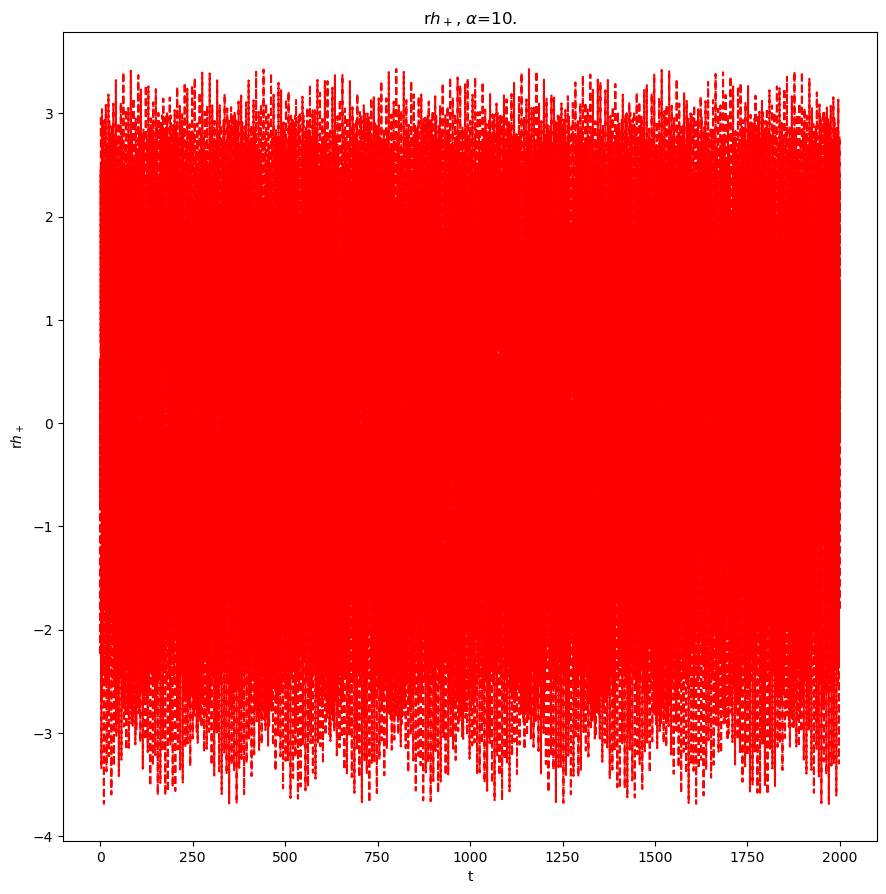

In [19]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(tm[:20000],R*hp10[:20000],'r--')
plt.title(r'r$h_+$, $\alpha$=10.')
plt.ylabel(r'r$h_+$')
plt.xlabel('t')

Text(0.5, 0, 't')

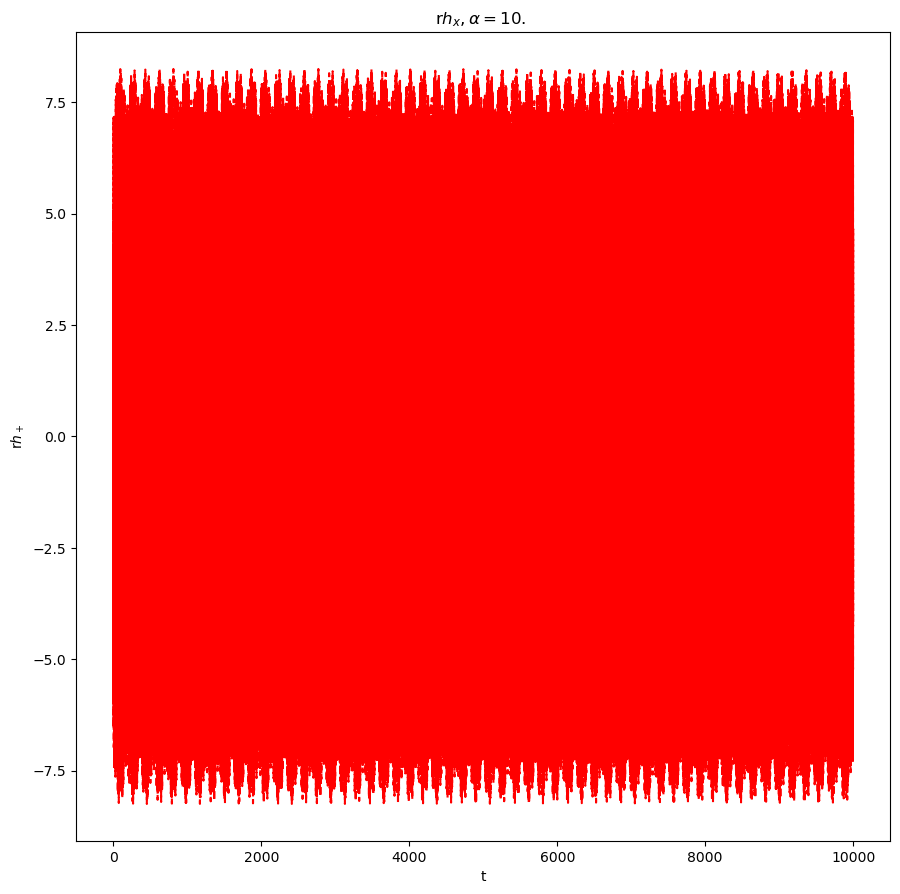

In [20]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(tm[:100000],R*hc10[:100000],'r--')
plt.title(r'r$h_x, \alpha=10.$ ')
plt.ylabel(r'r$h_+$')
plt.xlabel('t')

In [21]:
alpha=0.01

In [22]:
usol001, success = lsoda(funcptr, ics, tm,data=np.array((alpha)),atol=1e-12,rtol=1e-12)

In [23]:
hp001=hplus(0,usol001,R,mu,Theta,Psi,alpha)
hc001=hcross(0,usol001,R,mu,Theta,Psi,alpha)

Text(0.5, 0, 't')

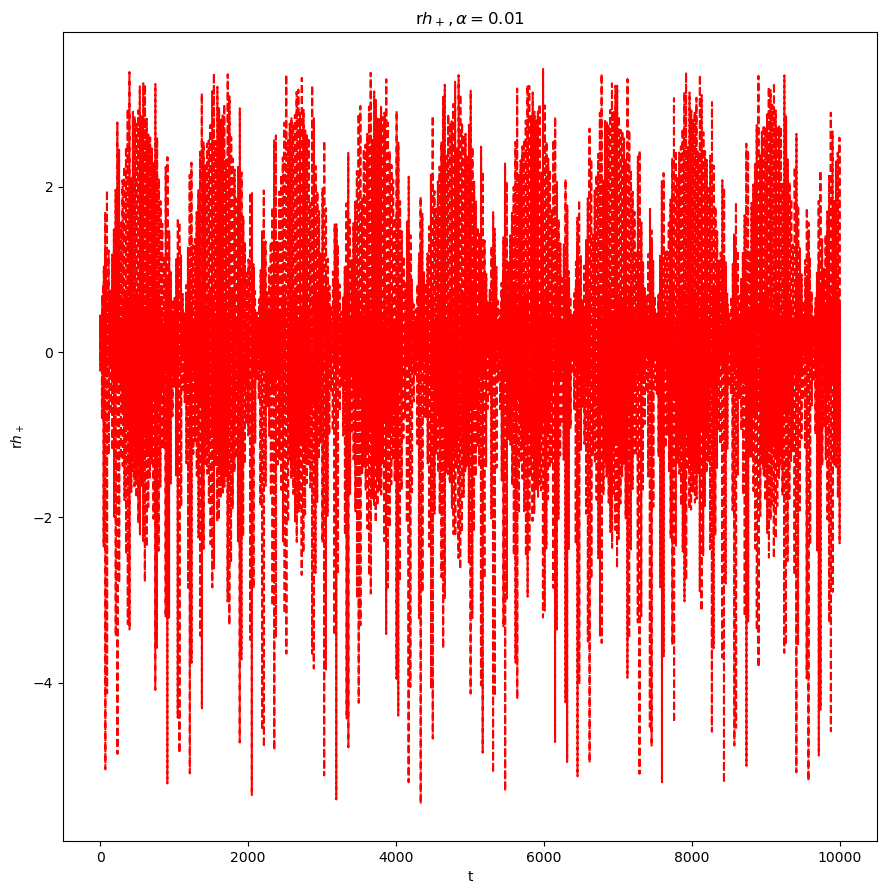

In [24]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(tm[:100000],R*hp001[:100000],'r--')
plt.title(r'r$h_+,\alpha=0.01$')
plt.ylabel(r'r$h_+$')
plt.xlabel('t')

Text(0.5, 0, 't')

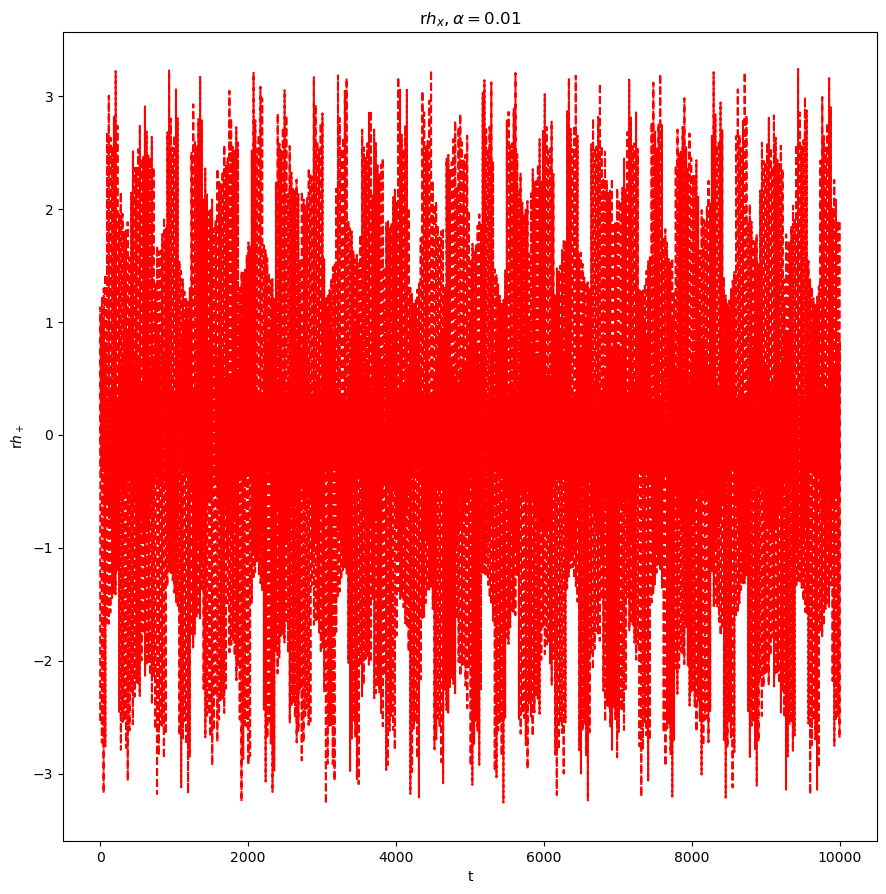

In [25]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(tm[:100000],R*hc001[:100000],'r--')
plt.title(r'r$h_x,\alpha=0.01$')
plt.ylabel(r'r$h_+$')
plt.xlabel('t')

In [26]:
alpha=0.1

In [27]:
usol01, success = lsoda(funcptr, ics, tm,data=np.array((alpha)),atol=1e-12,rtol=1e-12)

In [28]:
hp01=hplus(0,usol01,R,mu,Theta,Psi,alpha)
hc01=hcross(0,usol01,R,mu,Theta,Psi,alpha)

Text(0.5, 0, 't')

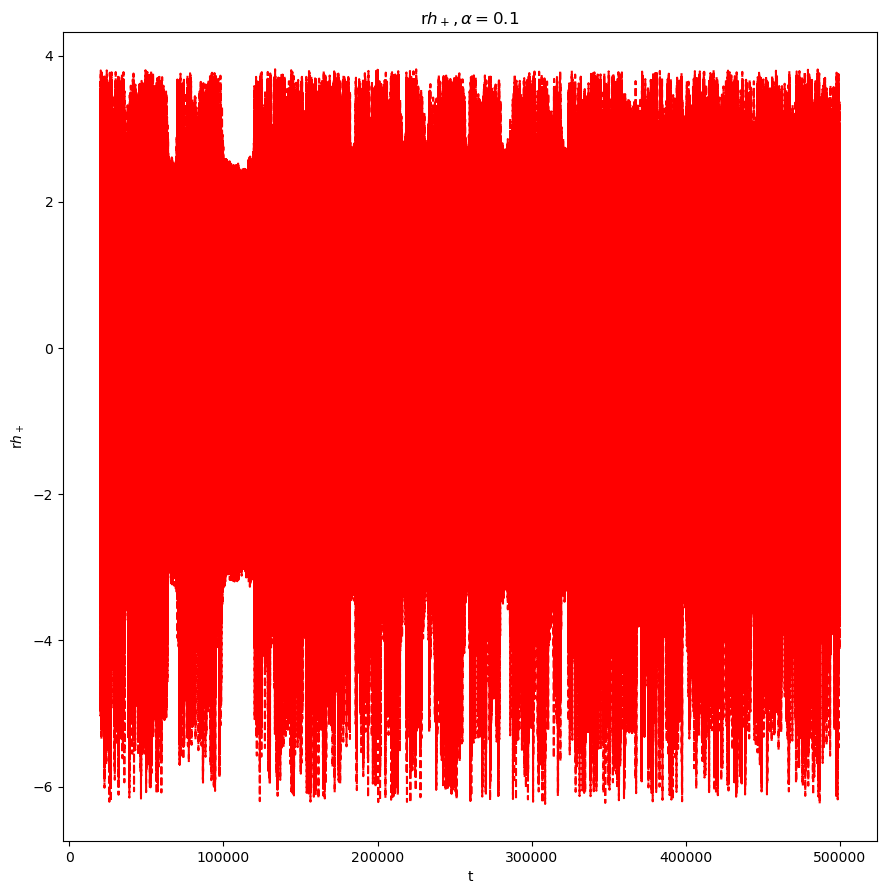

In [29]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(tm[200000:],R*hp01[200000:],'r--')
plt.title(r'r$h_+, \alpha=0.1$')
plt.ylabel(r'r$h_+$')
plt.xlabel('t')

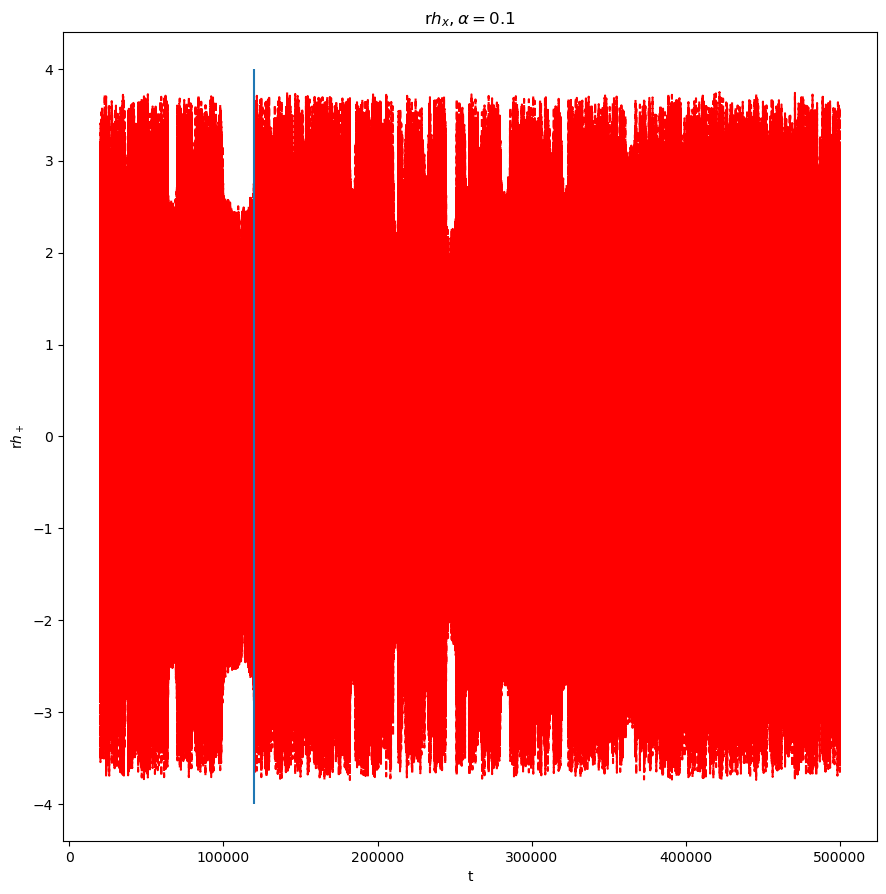

In [43]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(tm[200000:],R*hc01[200000:],'r--')
plt.title(r'r$h_x, \alpha=0.1$')
plt.ylabel(r'r$h_+$')
plt.xlabel('t')
plt.vlines(1.2e5,-4,4)

In [50]:
tm[1000000],tm[1200000]

(100000.020000004, 120000.0240000048)

Text(0.5, 1.0, 'r vs t')

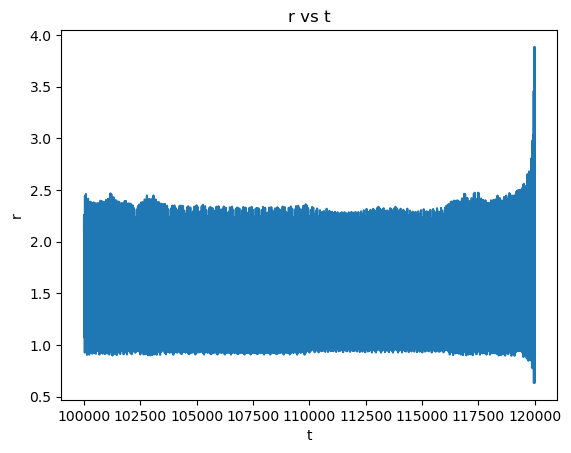

In [51]:
plt.plot(tm[1000000:1200000],usol01[:,0][1000000:1200000])
plt.xlabel('t')
plt.ylabel('r')
plt.title('r vs t')

In [32]:
# sol01=integrate.solve_ivp(evolve,(0.,tm[-1]),ics,'LSODA',t_eval=tm[190000:220000],events=poincare,args=(alpha,),atol=1e-9,rtol=1e-9)

In [33]:
def de_dw(t,hp,hc):
    """
    Calculate dE/dw 

    Args:
        t (ndarray): Time array between which to calculate the FFT, Shape: (n,)
        hp (ndarray): hplus array, Shape: (n,)
        hc (ndarray): hcross array, Shape: (n,)

    Returns:
        dEdw (ndarray): dEdw, shape(n//2,)
        df (ndarray): Fourier Transform Frequencies, shape(n//2,)
    """
    # window=np.hanning(t.size)
    fhp=np.fft.fft(hp,norm='ortho')
    fhc=np.fft.fft(hc,norm='ortho')
    N=len(fhc)

    dt=t[1]-t[0]
    # df=sp.fft.fftfreq(len(fhp),dt)[1:N//2]
    df=(np.arange(len(t))/(dt*N))[:N//2]
    # const=(3e8)**3/(4*6.674e-11)

    E=(np.abs(fhp)**2+np.abs(fhc)**2)[:N//2]
    dEdw=(E*df**2)*R**2

    return dEdw,df


In [55]:
tm[100000]

10000.0020000004

In [57]:
E001,f001=de_dw(tm[:100000],hp001[:100000],hc001[:100000])
#* For alpha=0.01

Text(0.5, 0, '$Log_{10}f$')

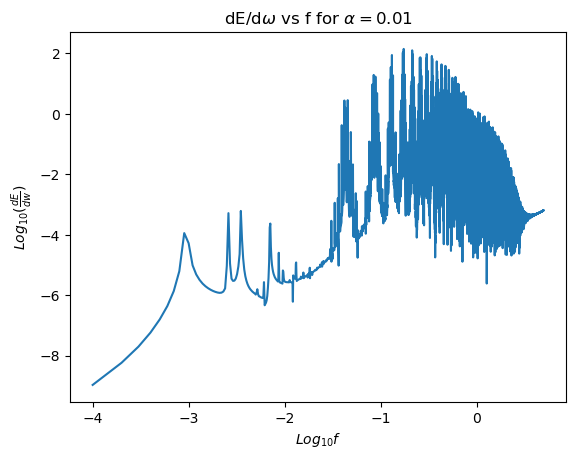

In [58]:
plt.plot(np.log10(f001[1:]),np.log10(E001[1:]))
plt.title(r'dE/d$\omega$ vs f for $\alpha=0.01$')
plt.ylabel(r'$Log_{10}(\frac{dE}{dw}$)')
plt.xlabel(r'$Log_{10}f$')

In [59]:
E01,f01=de_dw(tm[:],hp01[:],hc01[:])

Text(0.5, 0, '$Log_{10}f$')

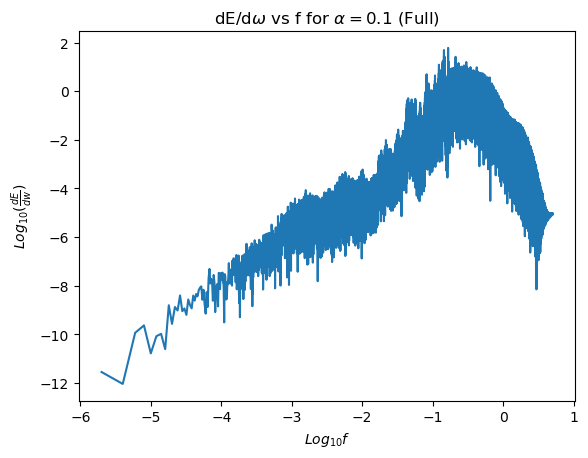

In [60]:
plt.plot(np.log10(f01[1:]),np.log10(E01[1:]))
plt.title(r'dE/d$\omega$ vs f for $\alpha=0.1$ (Full)')
plt.ylabel(r'$Log_{10}(\frac{dE}{dw}$)')
plt.xlabel(r'$Log_{10}f$')

In [38]:
E01b,f01b=de_dw(tm[300000:340000],hp01[300000:340000],hc01[300000:340000])

Text(0.5, 0, '$Log_{10}f$')

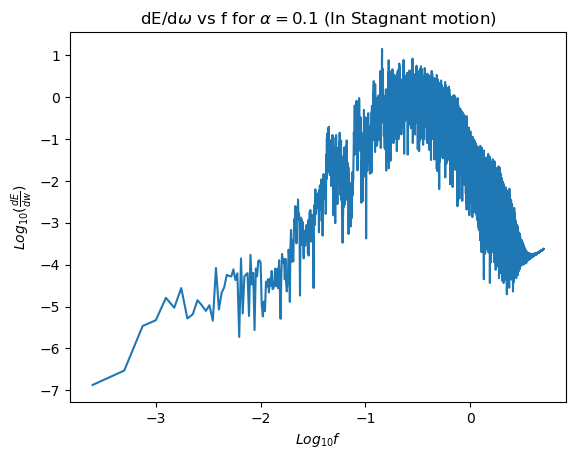

In [39]:
plt.plot(np.log10(f01b[1:]),np.log10(E01b[1:]))
plt.title(r'dE/d$\omega$ vs f for $\alpha=0.1$ (In Stagnant motion)')
plt.ylabel(r'$Log_{10}(\frac{dE}{dw}$)')
plt.xlabel(r'$Log_{10}f$')

In [40]:
E10,f10=de_dw(tm[:20000],hp10[:20000],hc10[:20000])

Text(0.5, 0, '$Log_{10}f$')

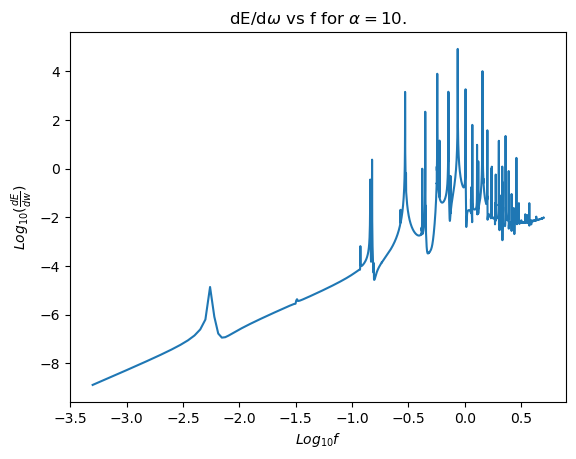

In [41]:
plt.plot(np.log10(f10[1:]),np.log10(E10[1:]))
plt.title(r'dE/d$\omega$ vs f for $\alpha=10.$')
plt.ylabel(r'$Log_{10}(\frac{dE}{dw}$)')
plt.xlabel(r'$Log_{10}f$')

# <span style="color:Red">Injecting Noise to signals </span>

In [62]:
noise=np.random.normal(0.,1.,len(hp10)) #* Normally distributed Random Noise

In [63]:
nhp10=hp10+noise #*Adding noise to signals
nhc10=hc10+noise

Text(0.5, 0, 't')

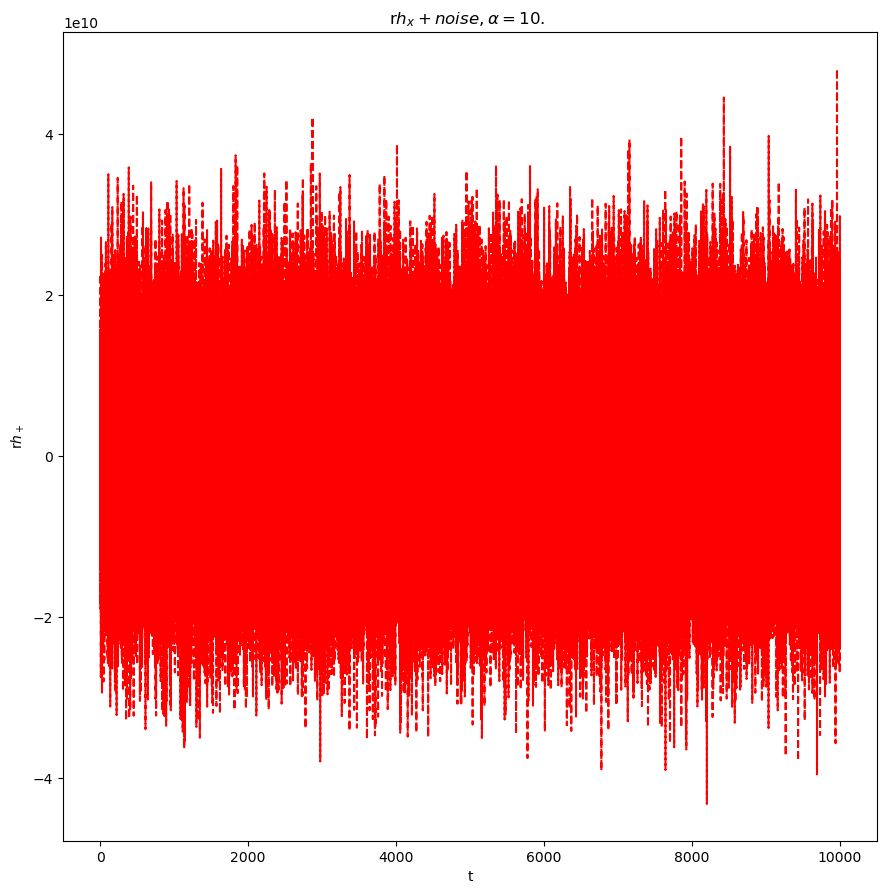

In [89]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(tm[:100000],R*nhc10[:100000],'r--')
plt.title(r'r$h_x+ noise, \alpha=10.$ ')
plt.ylabel(r'r$h_+$')
plt.xlabel('t')

Text(0.5, 0, 't')

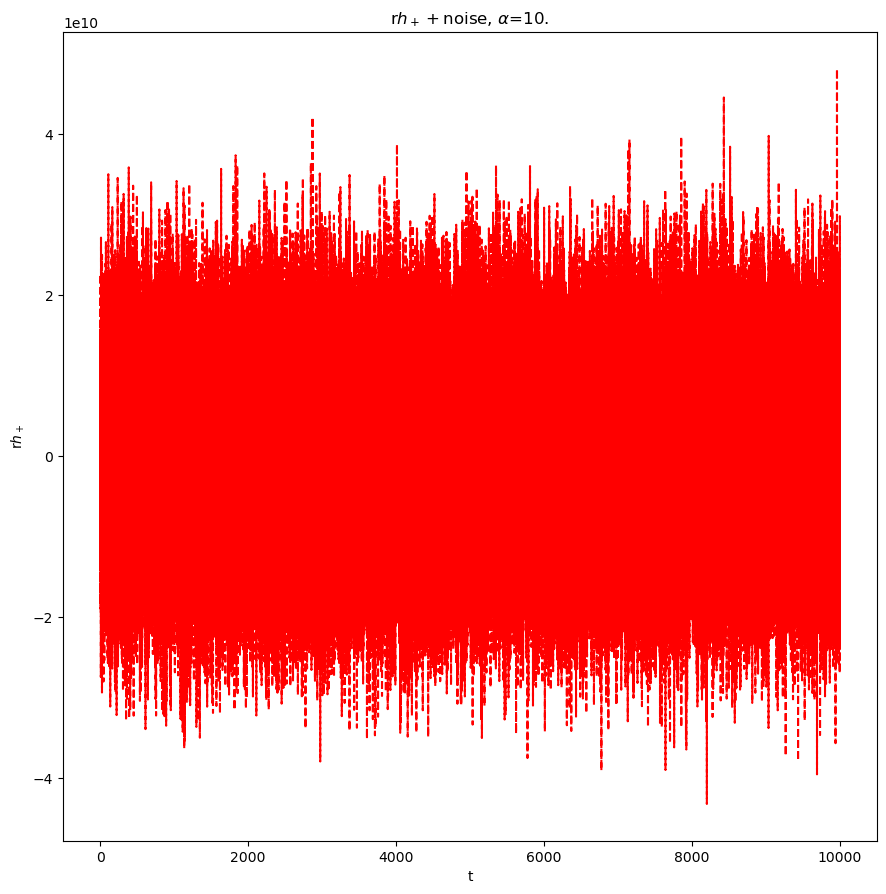

In [86]:
fig=plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.plot(tm[:100000],R*nhp10[:100000],'r--')
plt.title(r'r$h_++$noise, $\alpha$=10.')
plt.ylabel(r'r$h_+$')
plt.xlabel('t')

In [69]:

#! Get the energy spectra for noise with signals
NE10,nf10=de_dw(tm[:20000],nhp10[:20000],nhc10[:20000])

Text(0.5, 0, '$Log_{10}f$')

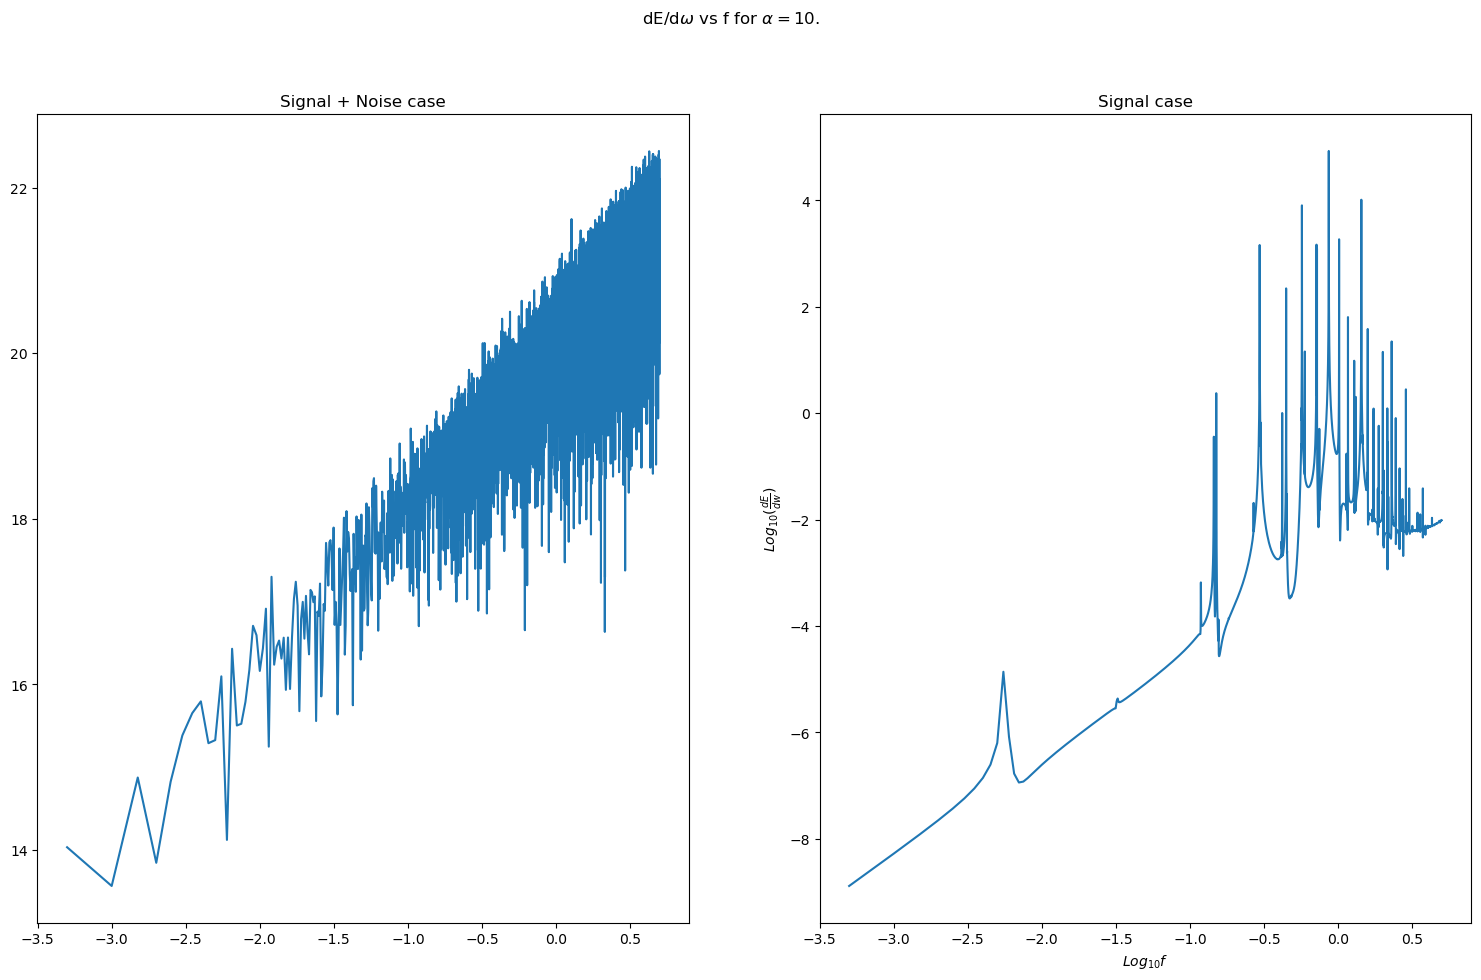

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.5, 10.5)
ax[0].plot(np.log10(nf10[1:]),np.log10(NE10[1:]))
ax[1].plot(np.log10(f10[1:]),np.log10(E10[1:]))
fig.suptitle(r'dE/d$\omega$ vs f for $\alpha=10.$')
ax[0].set_title('Signal + Noise case')
ax[1].set_title('Signal case')
plt.ylabel(r'$Log_{10}(\frac{dE}{dw}$)')
plt.xlabel(r'$Log_{10}f$')

In [72]:

#!Same case for different signal 
noise_2=np.random.normal(10.,3.,100000)
nhp001=hp001[:100000]+noise_2
nhc001=hc001[:100000]+noise_2
NE001,nf001=de_dw(tm[:100000],nhp001[:100000],nhc001[:100000])

Text(0.5, 0, '$Log_{10}f$')

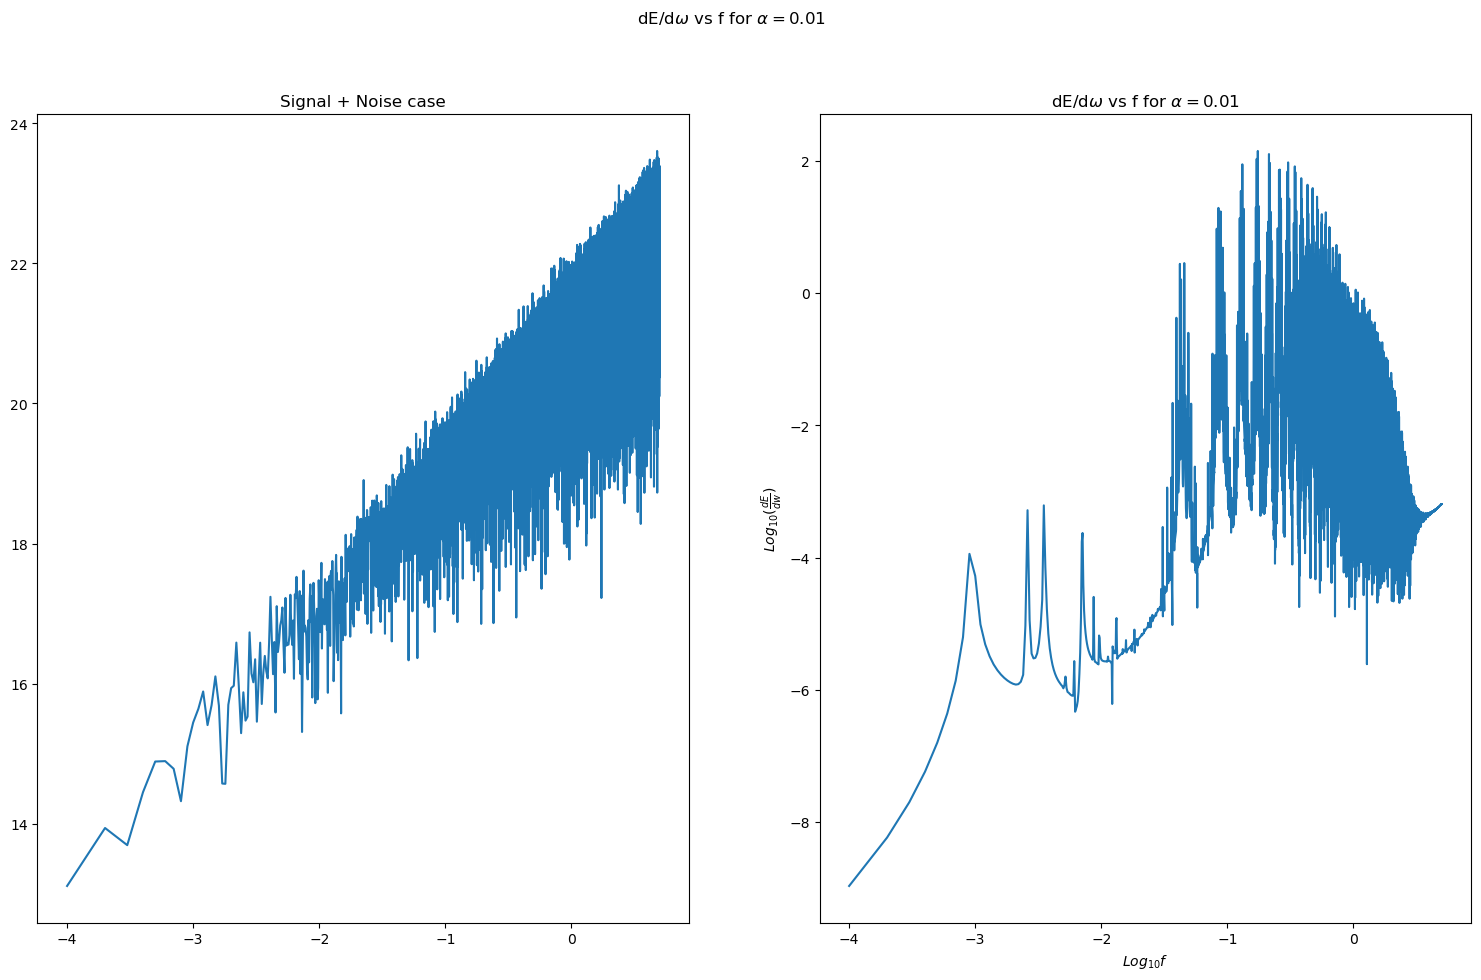

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.5, 10.5)
ax[0].plot(np.log10(nf001[1:]),np.log10(NE001[1:]))
ax[1].plot(np.log10(f001[1:]),np.log10(E001[1:]))
fig.suptitle(r'dE/d$\omega$ vs f for $\alpha=0.01$')
ax[0].set_title('Signal + Noise case')
ax[1].set_title('Signal case')
plt.title(r'dE/d$\omega$ vs f for $\alpha=0.01$')
plt.ylabel(r'$Log_{10}(\frac{dE}{dw}$)')
plt.xlabel(r'$Log_{10}f$')

We see in the above plot that there is very noisy signal at the end of spectra. I guess that this is due to the fact that since <span style="color: yellow">the noisy signals have high frequency, and in the formula we are multiplying with f**2, we expect to get high freqencies at the end of spectra.</span>

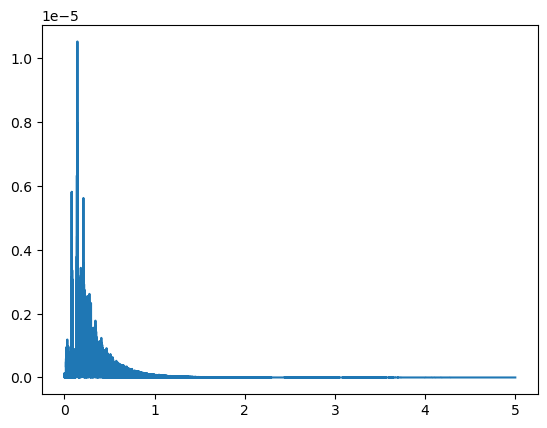

In [94]:

#! This figure shows the presence of high frequency signal in the data

N=len(hc01[200000:])
dt=tm[1]-tm[0]

sig=np.fft.fft(hc01[200000:])[:N//2] #! Take the Fourier Transform of signal
sigfreq=(np.arange(len(tm))/(dt*N))[:N//2] #!Get the frequencies

plt.plot(sigfreq,np.abs(sig)) #!Plot

# TODO
- <span style="color: Magenta">Write a code to Calculate the Fractal Dimension (or correlation dimension)</span>
- Use the following link to write the code (It is in the Mathematica. But it is easy to do in Python using KDTree) https://mathematica.stackexchange.com/questions/25984/how-can-i-calculate-the-correlation-dimension-and-or-the-lyapunov-exponent-of-a

# Some Other Measures:
- Entropy (Shannon Entropy or Kolmogrove-Sinai Entropy)
- Hurst Exponent
- Detrended Fluctuation Analysis

The following links can be used to learn the methods above:

Entropy: <br>
https://doi.org/10.1016/j.physd.2020.132816

Hurst Exponent: <br>
https://doi.org/10.1016/B978-0-12-820125-1.00014-2

Detrended Fluctuation Analysis: <br>
https://en.wikipedia.org/wiki/Detrended_fluctuation_analysis

Recurrence Plots: <br>
http://www.recurrence-plot.tk/glance.php#:~:text=Recurrence%20plot%20%E2%80%93%20A%20recurrence%20plot,a%20certain%20pair%20of%20times).
